In [1]:
# Install dependencies
!pip install -q kaggle pycocotools opencv-python pillow matplotlib tqdm albumentations


In [2]:
from google.colab import files
import os, shutil

uploaded = files.upload()  # Upload kaggle.json here

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("✅ kaggle.json configured")


Saving kaggle.json to kaggle.json
✅ kaggle.json configured


In [3]:
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-11-03 13:46:51--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.235.209, 16.15.217.76, 16.182.97.97, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.235.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  71.2MB/s    in 5m 12s  

2025-11-03 13:52:03 (59.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-11-03 13:52:03--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.197.161, 16.15.178.56, 52.216.58.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.197.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>]

In [4]:
!unzip -q -n train2017.zip
!unzip -q -n val2017.zip
!unzip -q -n annotations_trainval2017.zip

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tqdm import tqdm
import albumentations as A
from PIL import Image


In [6]:
# Paths for train dataset
IMG_DIR = "/content/train2017"       # training images
ANN_FILE = "/content/annotations/instances_train2017.json"  # COCO annotations for train

# Output folders
OUT_IMG_DIR = "/content/processed/train/images"
OUT_MASK_DIR = "/content/processed/train/masks"
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_MASK_DIR, exist_ok=True)

print("✅ Train dataset paths set")


✅ Train dataset paths set


In [7]:
coco = COCO(ANN_FILE)
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

print("Number of categories in train:", len(cats))
print("Some categories:", [c['name'] for c in cats[:10]])


loading annotations into memory...
Done (t=16.45s)
creating index...
index created!
Number of categories in train: 80
Some categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


In [8]:
transform = A.Compose([
    A.Resize(256, 256),                   # Resize all images/masks to 256x256
    A.HorizontalFlip(p=0.5),              # Random horizontal flip
    A.RandomRotate90(p=0.5),              # Random 90° rotation
    A.RandomBrightnessContrast(p=0.2),    # Adjust brightness/contrast
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])


In [11]:
from tqdm import tqdm
from PIL import Image
import numpy as np
import os
import cv2

img_ids = coco.getImgIds()
print("Total train images:", len(img_ids))

for img_id in tqdm(img_ids[:200]):  # process first 200 images for testing
    # Load image info and path
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, img_info['file_name'])

    # Load original image
    image = np.array(Image.open(img_path).convert('RGB'))

    # Load annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    # Create empty binary mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        binary = coco.annToMask(ann)
        mask = np.maximum(mask, binary)  # combine all object masks

    # Apply augmentation (same for image and mask)
    augmented = transform(image=image, mask=mask)
    img_resized = augmented['image']
    mask_resized = augmented['mask']

    # ---- Fix for visibility and sharpening ----
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img_vis = img_resized.astype(np.float32)
    img_vis = (img_vis * std) + mean           # reverse normalization
    img_vis = np.clip(img_vis, 0, 1)
    img_vis = (img_vis * 255).astype(np.uint8)

    # Sharpen the image
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_vis, -1, kernel)

    # Save processed image and binary mask
    fname = os.path.splitext(img_info['file_name'])[0]
    Image.fromarray(img_sharp).save(f"{OUT_IMG_DIR}/{fname}.png")
    Image.fromarray((mask_resized * 255).astype(np.uint8)).save(f"{OUT_MASK_DIR}/{fname}.png")


Total train images: 118287


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


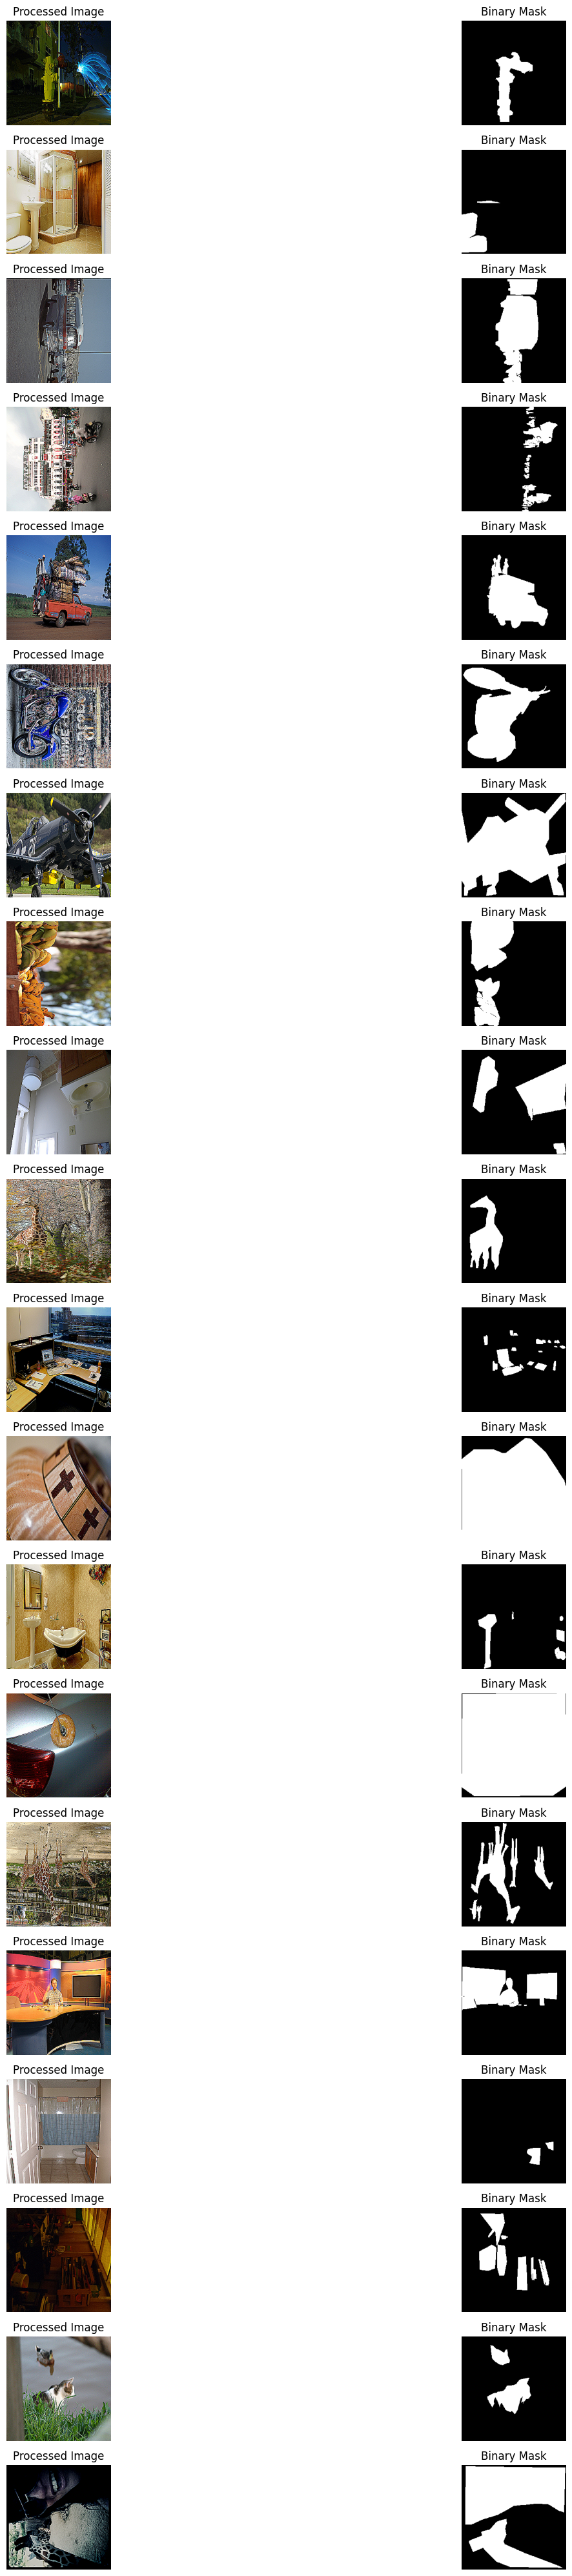

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Get list of processed images
proc_images = sorted(os.listdir(OUT_IMG_DIR))
n_show = min(20, len(proc_images))  # Show 20 images or fewer if less exist
samples = random.sample(proc_images, n_show)

plt.figure(figsize=(20, 40))  # Wide figure for side-by-side

for i, fn in enumerate(samples):
    # Load processed image and corresponding mask
    img = np.array(Image.open(os.path.join(OUT_IMG_DIR, fn)))
    mask = np.array(Image.open(os.path.join(OUT_MASK_DIR, fn)))

    # Original (processed) image
    plt.subplot(n_show, 2, i*2 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Processed Image")

    # Binary mask
    plt.subplot(n_show, 2, i*2 + 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Binary Mask")

plt.tight_layout()
plt.show()

